In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import json
import math
import os

import cv2
from PIL import Image
# from keras_efficientnets import *
from keras import layers

from keras.callbacks import Callback, ModelCheckpoint,EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
print(os.listdir('../input'))
%matplotlib inline

IMG_SIZE=256
BATCH_SIZE = 16

['aptos2019-blindness-detection']


In [3]:
train_df = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test_df = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [4]:
train_df.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [5]:
train_df['diagnosis'].value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

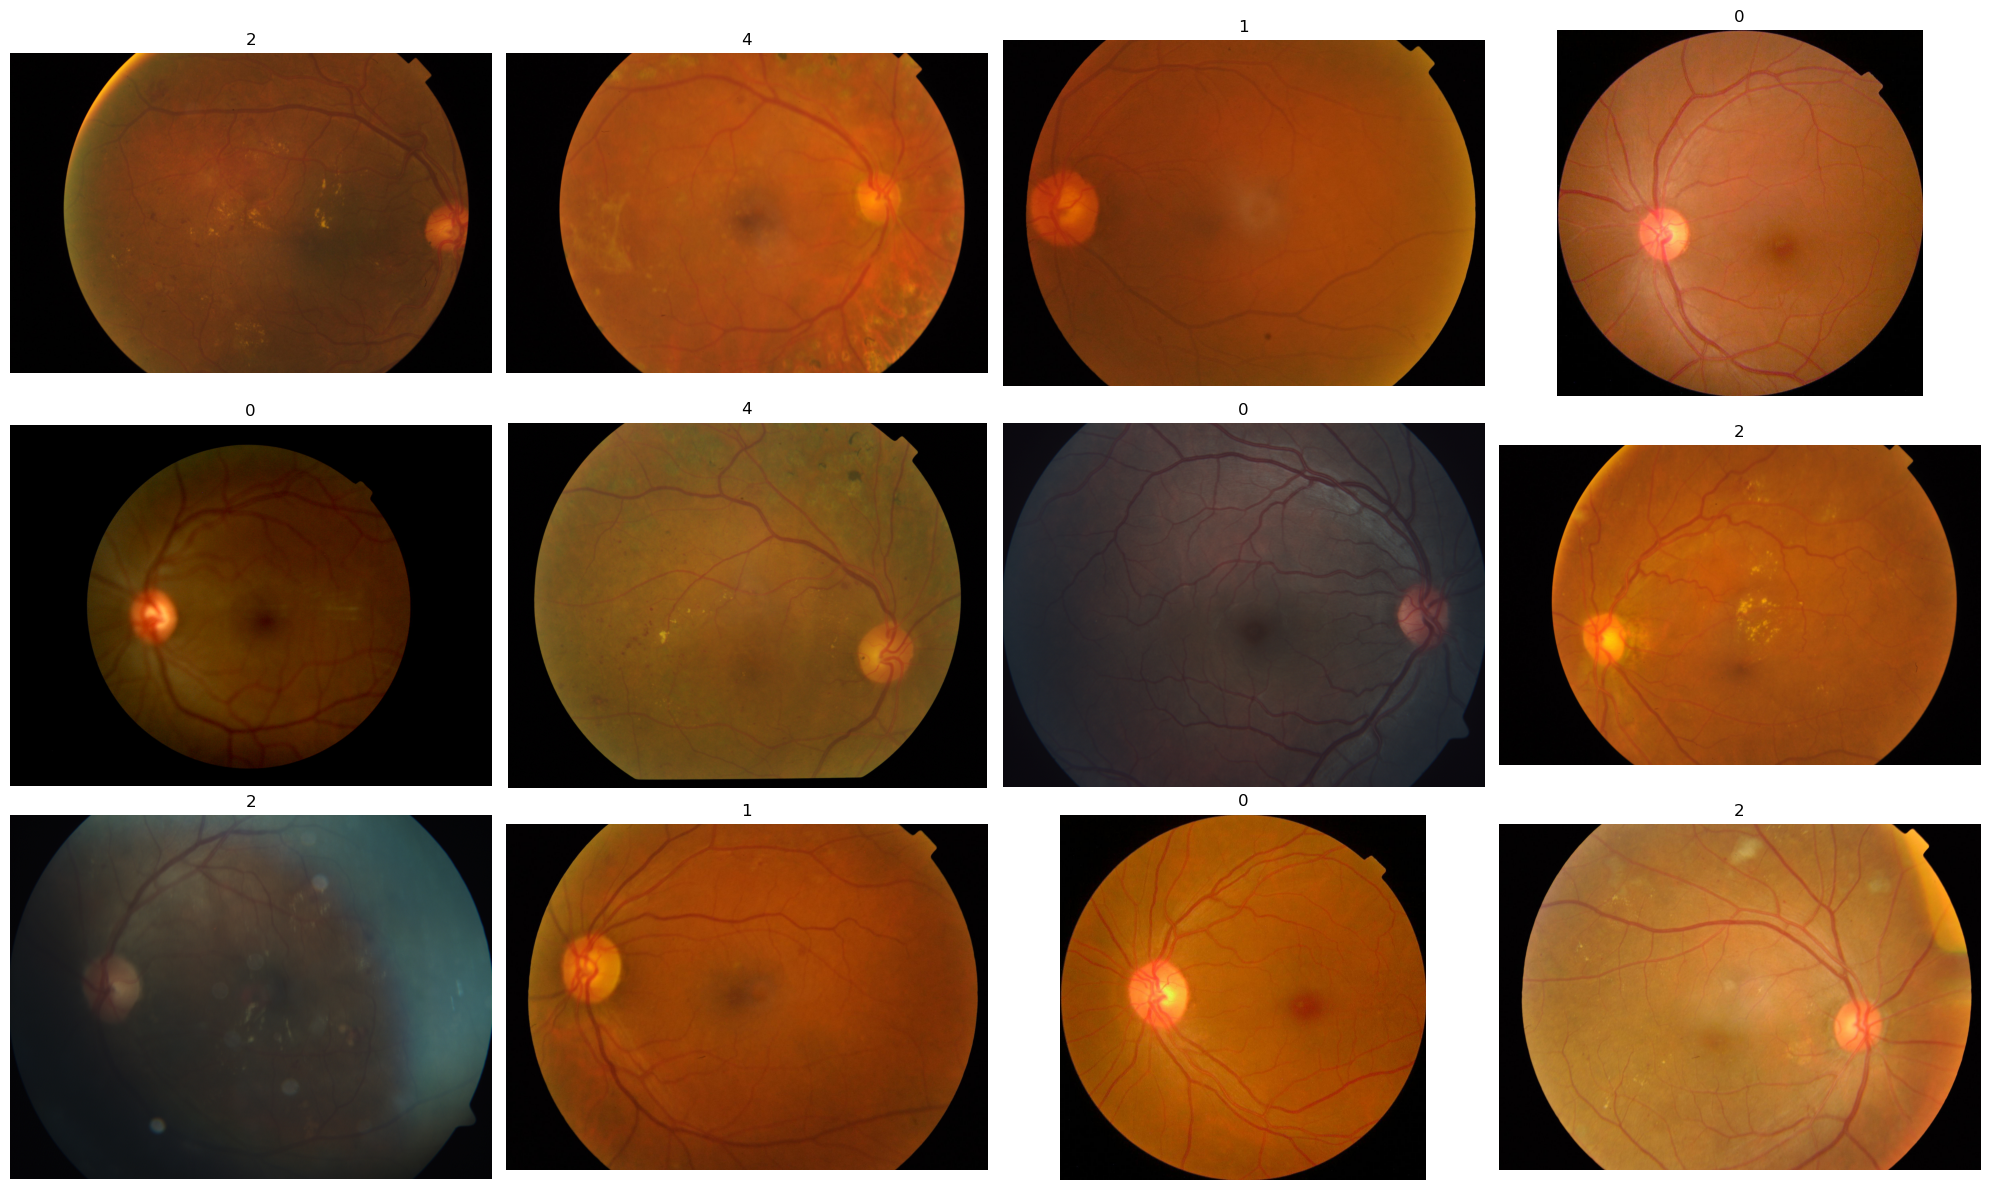

In [6]:


def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)



In [7]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def preprocess_image(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
#     image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
    image=CLAHEgreen(image)
        
    return image

def CLAHEgreen(image):
    green=image[:, :, 1]
    clipLimit = 2.0
    tileGridSize = (8,8)
    clahe=cv2.createCLAHE(clipLimit = clipLimit, tileGridSize = tileGridSize)
    cla=clahe.apply(green)
#     cla=clahe.apply(cla)
    img=cv2.merge((cla,cla,cla))
    
    return img

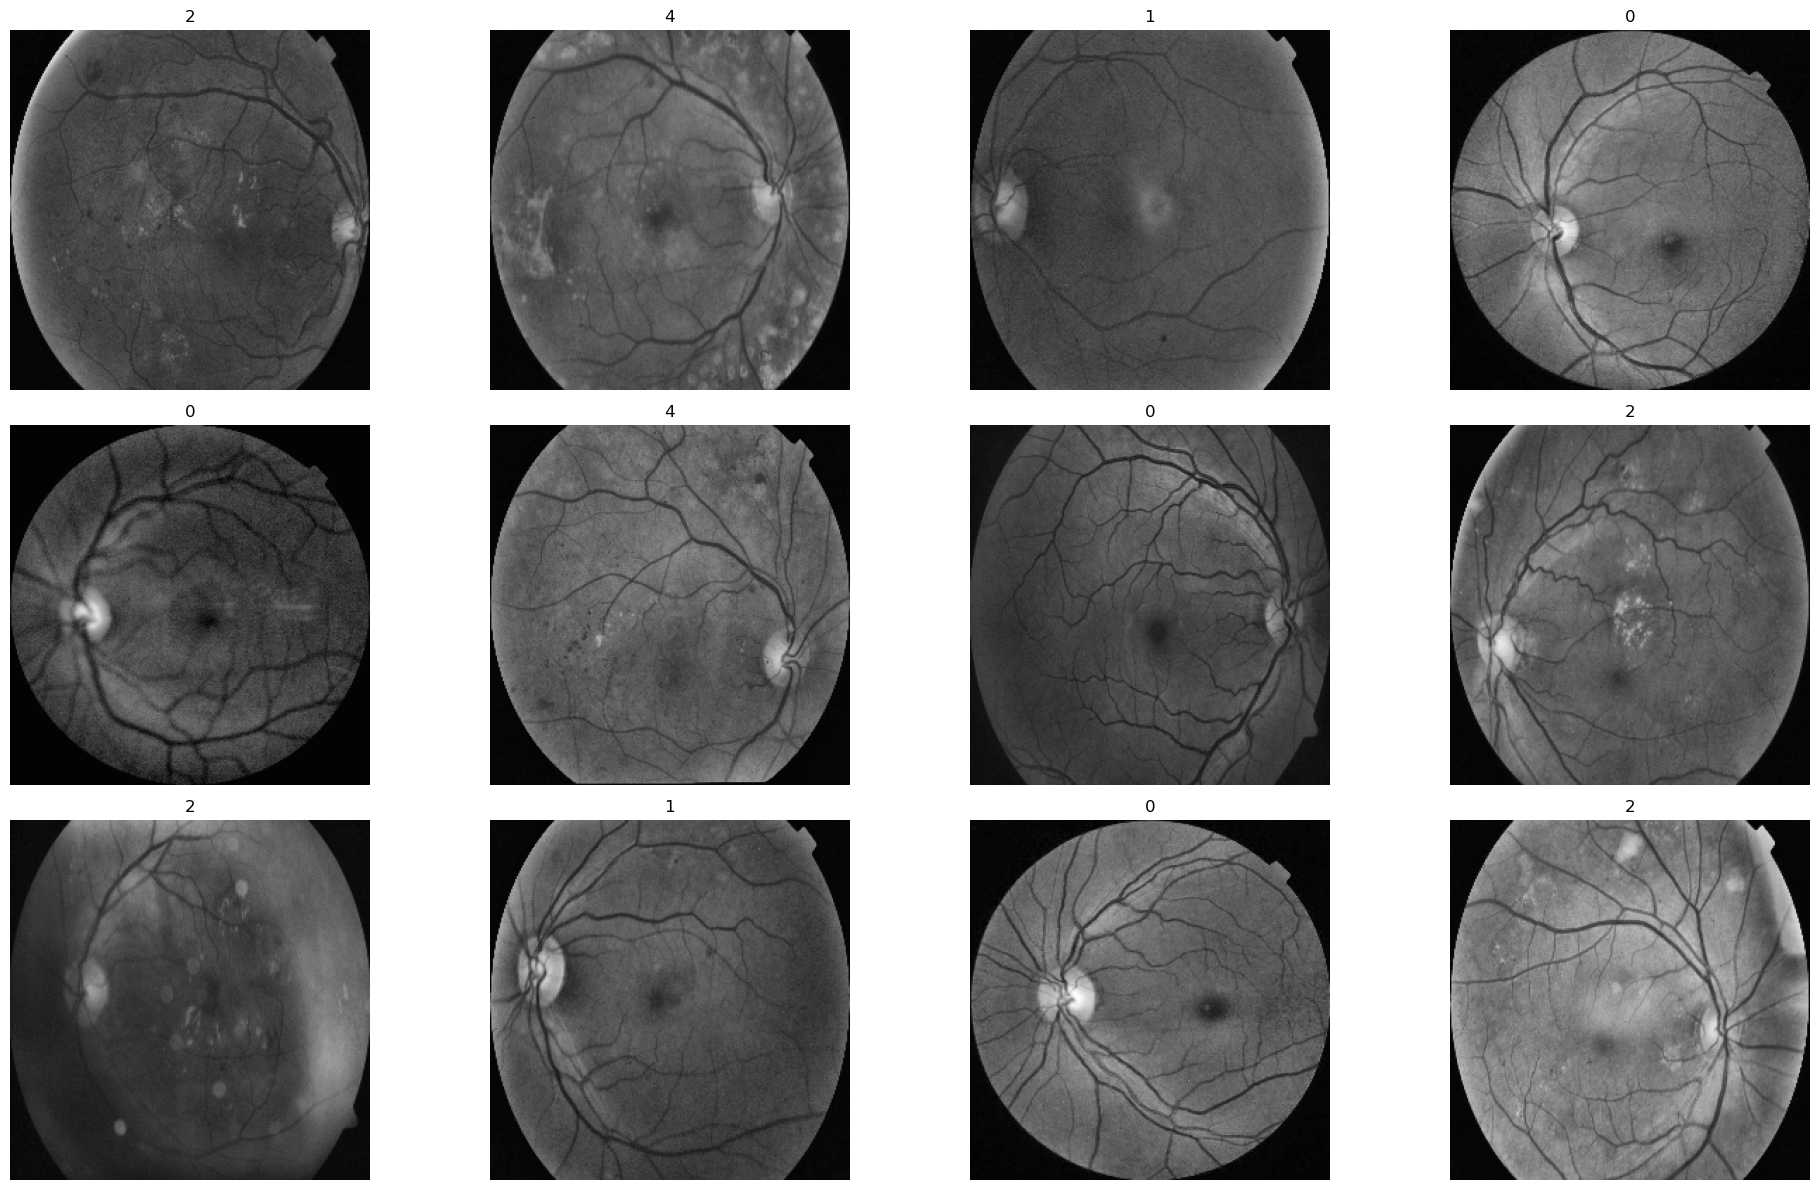

In [8]:
def display_samples_gaussian(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = preprocess_image(f'../input/aptos2019-blindness-detection/train_images/{image_path}.png')
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.axis('off')
        plt.imshow(img)
    
    plt.tight_layout()

display_samples_gaussian(train_df)


In [9]:


# import pandas as pd
# import cv2
# import os

# from tqdm.notebook import tqdm



In [10]:
# file = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')



In [11]:


# file.head()



In [12]:
no_dr = 'No_DR/'
mild = 'Mild/'
moderate = 'Moderate/'
severe = 'Severe/'
proliferate_dr = 'Proliferate_DR/'

In [13]:
# train_y = file['diagnosis']
# print(train_y.head())
# # get the number of images per category
# num_img_by_cat = (train_y.value_counts())
# print(num_img_by_cat, type(num_img_by_cat))

In [14]:
# # gaussian filtering constants
# sigmaX = 10





In [15]:
os.chdir(r'/kaggle/working/')

In [16]:
# import os
# os.chdir(r'/kaggle/working/gaussian_filtered_images')

# !tar -czf Landscapes.tar gaussian_filtered_images

# from IPython.display import FileLink

# FileLink(r'gaussian_filtered_images.tar')

In [17]:
# %%!
# zip -r processed_images.zip /kaggle/working/gaussian_filtered_images

In [18]:
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

# Define the input and output directories
input_dir = Path('/kaggle/input/aptos2019-blindness-detection/train_images')
output_dir = Path('/kaggle/working/images_segregated/')

# Define a dictionary to store the different class labels and corresponding folder names
class_labels = {0: 'no_dr', 1: 'mild', 2: 'moderate', 3: 'severe', 4: 'proliferate_dr'}

# Read the CSV file containing the image filenames and labels
df = pd.read_csv('/kaggle/input/aptos2019-blindness-detection/train.csv')

# Loop through each class label
for class_id in tqdm(sorted(df['diagnosis'].unique())):
    # Get the number of images to sample for the current class label
    num_images = df['diagnosis'].value_counts()[class_id]
    
    # Get the corresponding folder name for the current class label
    folder_name = class_labels[class_id]
    
    # Create the output directory if it doesn't exist
    (output_dir / folder_name).mkdir(parents=True, exist_ok=True)
    
    # Loop through the images in the current class label
    for i, row in tqdm(df.loc[df['diagnosis'] == class_id].sample(num_images).iterrows()):
        # Create the input and output file paths
        read_path = input_dir / f"{row['id_code']}.png"
        write_path = output_dir / folder_name / f"{row['id_code']}.png"
        
        try:
            # Read the input image
            image = cv2.imread(str(read_path))
            
            # Resize the image to 224x224
#             resized = cv2.resize(image, (224, 224))
            p_img=preprocess_image(str(read_path))
            # Write the output image to file
            cv2.imwrite(str(write_path), p_img)
        except Exception as e:
            print(f"Error processing image {read_path}: {str(e)}")


  0%|          | 0/5 [00:00<?, ?it/s]
0it [00:00, ?it/s]
2it [00:00,  9.94it/s]
3it [00:00,  8.83it/s]
4it [00:00,  5.99it/s]
5it [00:00,  6.54it/s]
6it [00:01,  3.53it/s]
7it [00:01,  4.23it/s]
8it [00:01,  4.14it/s]
9it [00:01,  4.05it/s]
10it [00:02,  4.72it/s]
11it [00:02,  4.43it/s]
13it [00:02,  5.94it/s]
14it [00:02,  6.26it/s]
15it [00:02,  6.51it/s]
16it [00:03,  5.51it/s]
17it [00:03,  5.96it/s]
18it [00:03,  6.33it/s]
19it [00:03,  5.39it/s]
20it [00:03,  5.89it/s]
22it [00:03,  7.23it/s]
23it [00:04,  5.85it/s]
24it [00:04,  5.16it/s]
26it [00:04,  7.35it/s]
27it [00:05,  4.59it/s]
28it [00:05,  4.88it/s]
29it [00:05,  5.40it/s]
30it [00:05,  5.80it/s]
31it [00:05,  5.07it/s]
32it [00:05,  5.62it/s]
33it [00:05,  6.06it/s]
34it [00:06,  6.46it/s]
35it [00:06,  6.72it/s]
36it [00:06,  4.70it/s]
37it [00:07,  3.21it/s]
39it [00:07,  4.67it/s]
41it [00:07,  6.55it/s]
42it [00:07,  6.69it/s]
43it [00:07,  6.34it/s]
44it [00:08,  5.48it/s]
45it [00:08,  3.72it/s]
46it [00:08,  3